In [1]:
%load_ext lab_black
# load pretty jupyter's magics
%load_ext pretty_jupyter

In [2]:
# Please import here all the necessary libraries
import pandas as pd
import csv

# import io
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np

# plt.rcParams["figure.figsize"] = (20,7)
from math import sqrt
from tqdm import tqdm
import plotly.graph_objects as go
import chart_studio.plotly as py
import os
import datacube
from scipy.stats import loguniform, uniform
from matplotlib.pyplot import figure
import geopandas as gpd
import openpyxl
import math
from itertools import combinations
import ipywidgets as widgets
from shapely.geometry import Polygon

# import plotly.express as px
import rioxarray as rio
from plotly.subplots import make_subplots
import plotly.express as px
import joblib
import contextily as ctx
import matplotlib.cm as cm
import matplotlib.colors as mcolors
from matplotlib.ticker import MaxNLocator
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D
import statsmodels.api as sm
from statsmodels.graphics.gofplots import qqplot, qqplot_2samples

# ML
# from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
# import pmdarima as pm
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler, PolynomialFeatures, SplineTransformer

# import torch
# import torch.nn as nn
# from torch.autograd import Variable
from tensorflow import keras

# from keras_tuner.tuners import BayesianOptimization
from sklearn.ensemble import (
    RandomForestRegressor,
    GradientBoostingRegressor,
    VotingRegressor,
    StackingRegressor,
)
from sklearn.svm import SVR
from sklearn import tree
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import Ridge
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import (
    RBF,
    RationalQuadratic,
    CompoundKernel,
    WhiteKernel,
)
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split

# Feature Selection
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.linear_model import RidgeCV
from joblib import dump, load
from scipy import stats
import tensorflow as tf

# from tensorflow.keras import datasets, layers, models

# Hide Warnings
import warnings

warnings.filterwarnings("ignore")

# Functions

### Scaling

In [3]:
def scale_data(train_data, test_data):
    # Define scalers, f is for all features, t is for the 'y' we want to predict
    # We have two different scalers because we only want to scale features without considering the result
    # Also we are not scaling with the testing data, to avoid leakage from testing to training data
    f_transformer = MinMaxScaler()
    t_transformer = MinMaxScaler()
    # Fit scalers
    f_transformer = f_transformer.fit(train_data[:, 1:])
    t_transformer = t_transformer.fit((train_data[:, 0]).reshape(len(train_data), 1))
    # here we scale the X training data with its transformer
    train_data_X = f_transformer.transform(train_data[:, 1:])
    # here we scale the Y training data with its transformer. We reshape twice to first scale and then insert that
    # data into the original array
    train_data_y = (
        t_transformer.transform((train_data[:, 0]).reshape(len(train_data), 1))
    ).reshape(len(train_data), 1)
    # here we scale testing data with the training scalers
    test_data_X = f_transformer.transform(test_data[:, 1:])
    test_data_y = t_transformer.transform(
        (test_data[:, 0]).reshape(len(test_data), 1)
    ).reshape(len(test_data), 1)
    # here we create the new tran and test datasets
    train_data = np.concatenate((train_data_y, train_data_X), axis=1)
    test_data = np.concatenate((test_data_y, test_data_X), axis=1)
    return (
        f_transformer,
        t_transformer,
        train_data,
        test_data,
        train_data_X,
        train_data_y,
        test_data_X,
        test_data_y,
    )

### Plot

In [4]:
import plotly.graph_objects as go


def plot_estimations_sensors(
    test_df, inv_yhat_RF, row, col, sensor, remove_background=False
):
    legend = dict(
        yanchor="top",
        y=1.0,
        xanchor="left",
        x=1.05,
        traceorder="normal",
        bgcolor="white",
        borderwidth=1,
        bordercolor="gray",
        font=dict(
            size=11,
        ),
    )

    # Prepare data
    df_forecasted = test_df[["ground_no2", "satellite_no2"]]
    df_forecasted.insert(2, "pred", inv_yhat_RF)

    # Plot true ground NO2
    fig.add_trace(
        go.Scatter(
            y=df_forecasted["ground_no2"],
            x=df_forecasted.index,
            mode="markers",  # Use dots instead of lines
            name="True ground NO2",
            marker=dict(color="#2790db", size=5),
        ),
        row=row,
        col=col,
    )

    # Plot estimation ground NO2
    fig.add_trace(
        go.Scatter(
            y=df_forecasted["pred"],
            x=df_forecasted.index,
            mode="markers",  # Use dots instead of lines
            name="Estimation ground NO2",
            marker=dict(color="#fc5203", size=5),
        ),
        row=row,
        col=col,
    )

    # Update axes
    fig.update_xaxes(
        title_text="Date",
        showgrid=True,
        gridwidth=1,
        gridcolor="LightGray",
        mirror=True,
        ticks="outside",
        showline=True,
        linecolor="gray",
    )
    fig.update_yaxes(
        title_text="NO<sub>2</sub> [µg/m<sup>3</sup>]",
        showgrid=True,
        gridwidth=1,
        gridcolor="LightGray",
        mirror=True,
        ticks="outside",
        showline=True,
        linecolor="gray",
    )

    # Add range breaks
    fig.update_xaxes(rangebreaks=[dict(bounds=["2022-08-09", "2022-08-23"])])

    # Update layout
    fig.update_layout(
        title=go.layout.Title(text="Sensor: " + str(sensor)), legend=legend
    )

    # Optionally remove background
    if remove_background:
        fig.update_layout(paper_bgcolor="rgba(0,0,0,0)", plot_bgcolor="rgba(0,0,0,0)")
    # fig.show()

In [37]:
import plotly.graph_objects as go


def plot_grd_vs_sat(test_df, row, col, sensor, remove_background=False):
    legend = dict(
        yanchor="top",
        y=1.0,
        xanchor="left",
        x=1.05,
        traceorder="normal",
        bgcolor="white",
        borderwidth=1,
        bordercolor="gray",
        font=dict(
            size=11,
        ),
    )

    # Plot true ground NO2
    fig.add_trace(
        go.Scatter(
            y=test_df["ground_no2"],
            x=test_df.index,
            mode="markers",  # Use dots instead of lines
            name="True ground NO2",
            marker=dict(color="#2790db", size=5),
        ),
        row=row,
        col=col,
    )

    # Plot estimation ground NO2
    fig.add_trace(
        go.Scatter(
            y=test_df["satellite_no2"],
            x=test_df.index,
            mode="markers",  # Use dots instead of lines
            name="Sentinel-5P NO2",
            marker=dict(color="#fc5203", size=5),
        ),
        row=row,
        col=col,
    )

    # Update axes
    fig.update_xaxes(
        title_text="Date",
        showgrid=True,
        gridwidth=1,
        gridcolor="LightGray",
        mirror=True,
        ticks="outside",
        showline=True,
        linecolor="gray",
    )
    fig.update_yaxes(
        title_text="NO<sub>2</sub> [µg/m<sup>3</sup>]",
        showgrid=True,
        gridwidth=1,
        gridcolor="LightGray",
        mirror=True,
        ticks="outside",
        showline=True,
        linecolor="gray",
    )

    # Add range breaks
    fig.update_xaxes(rangebreaks=[dict(bounds=["2022-08-09", "2022-08-23"])])

    # Update layout
    fig.update_layout(
        title=go.layout.Title(text="Sensor: " + str(sensor)), legend=legend
    )

    # Optionally remove background
    if remove_background:
        fig.update_layout(paper_bgcolor="rgba(0,0,0,0)", plot_bgcolor="rgba(0,0,0,0)")
    # fig.show()

# NO$_2$ Sensor Testing (random dates)

In [5]:
df_complete = pd.read_csv(
    "/Users/rodrigo/Documents/2_PoliMi/3_Research/Pollution/Prediction/Data/cdmx-df_complete-2024_06_05.csv",
    index_col=0,
)
df_complete.set_index("date", inplace=True)
df_complete.drop(columns=["geometry", "id"], inplace=True)

cols = [
    "ground_no2",
    "station",
    "satellite_no2",
    "curr_temp_celsius",
    "curr_surface_net_solar_radiation",
    "curr_surface_pressure",
    "prev_temp_celsius",
    "prev_surface_net_solar_radiation",
]

df_complete = df_complete[cols]


best_mod = joblib.load(
    "./models_export/2023_10-13_rmse_best_mod_all_stations_separate_random_split.joblib"
)

In [6]:
station_list = []
for station in df_complete["station"].unique():
    size_2022 = len(
        df_complete[
            (df_complete.index > "2022-01-01") & (df_complete["station"] == station)
        ]
    )
    if size_2022 > 3:
        station_list.append(station)

station_list

['ACO',
 'AJM',
 'ATI',
 'BJU',
 'CAM',
 'CCA',
 'CHO',
 'CUA',
 'CUT',
 'FAC',
 'GAM',
 'IZT',
 'FAR']

In [7]:
current_sensors = df_complete[df_complete.index > "2022-02-01"]["station"].unique()
current_sensors

df_complete = df_complete[df_complete["station"].isin(station_list)]
df_complete = df_complete[df_complete["station"] != "ACO"]
df_complete = df_complete[df_complete["station"] != "AJM"]
df_complete = df_complete[df_complete["station"] != "CHO"]

In [8]:
df_complete[df_complete.index > "2022-05-01"]["station"].unique()

array(['ATI', 'BJU', 'CCA', 'CUA', 'CUT', 'FAC', 'FAR', 'GAM', 'IZT',
       'CAM'], dtype=object)

In [9]:
# -------------- Divide in Train/Test --------------

df_train_dates = pd.read_csv(
    "/Users/rodrigo/Documents/2_PoliMi/3_Research/Pollution/Prediction/Data/train_dates-original.csv"
)
df_test_dates = pd.read_csv(
    "/Users/rodrigo/Documents/2_PoliMi/3_Research/Pollution/Prediction/Data/test_dates-original.csv"
)

train = df_complete[df_complete.index.isin(df_train_dates["date"])]
test = df_complete[df_complete.index.isin(df_test_dates["date"])]

train_X = train.iloc[:, 1:]
test_X = test.iloc[:, 1:]
train_y = train.iloc[:, 0:2]
test_y = test.iloc[:, 0:2]

In [10]:
test_X.index < "2022-01-01"

array([ True,  True,  True, ..., False, False, False])

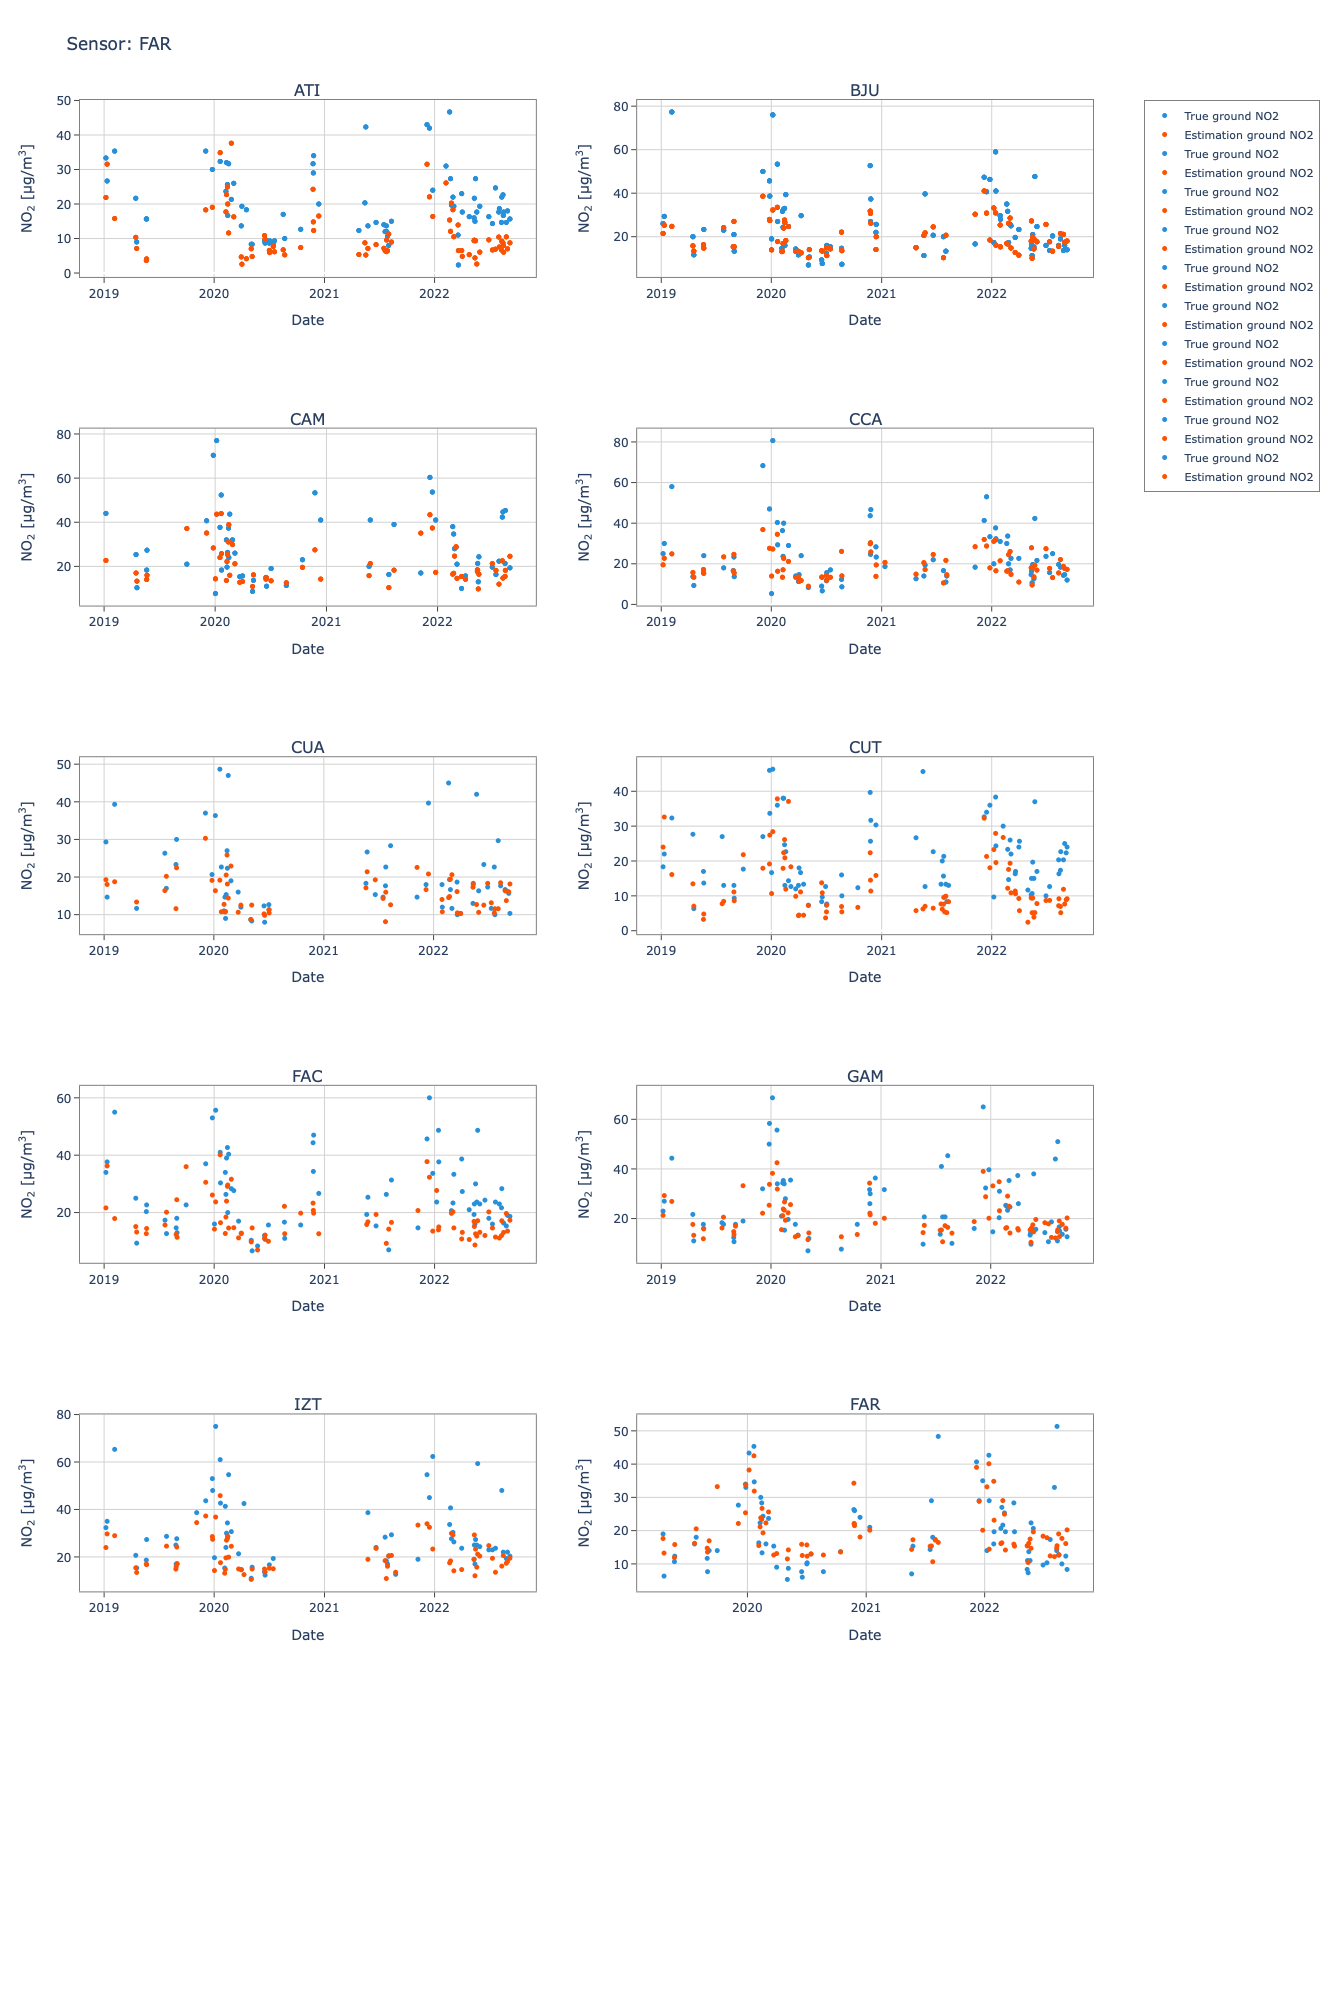

<Figure size 640x480 with 0 Axes>

In [13]:
sensors_list = df_complete["station"].unique()
sensors_list_str = [str(x) for x in sensors_list]
sensors_df = pd.DataFrame(columns=["sensor", "NRMSE", "RMSE", "Corr", "St_Dev"])

# DataFrames to store predictions and true values
all_test_y_sensor = pd.DataFrame()
all_inv_yhat_bst = pd.DataFrame()

fig = go.Figure()
column = 1
row = 1
fig = make_subplots(
    cols=2, rows=int(len(sensors_list) / 2) + 1, subplot_titles=(sensors_list_str)
)

(
    f_trans,
    t_trans,
    s_train_data,
    s_test_data,
    s_train_X,
    s_train_y,
    s_test_X,
    s_test_y,
) = scale_data(
    train[train.drop(columns="station").columns].values,
    test[test.drop(columns="station").columns].values,
)

for sensor in sensors_list:
    train_X_sensor = train_X[train_X["station"] == sensor]
    test_X_sensor = test_X[test_X["station"] == sensor]
    train_y_sensor = train_y[train_y["station"] == sensor]
    test_y_sensor = test_y[test_y["station"] == sensor]

    train_X_sensor.drop(["station"], axis=1, inplace=True)
    test_X_sensor.drop(["station"], axis=1, inplace=True)
    train_y_sensor.drop(["station"], axis=1, inplace=True)
    test_y_sensor.drop(["station"], axis=1, inplace=True)

    train_X_sensor.sort_index(inplace=True)
    test_X_sensor.sort_index(inplace=True)
    train_y_sensor.sort_index(inplace=True)
    test_y_sensor.sort_index(inplace=True)

    train_sensor = pd.concat(
        [train_y_sensor, train_X_sensor], axis=1, ignore_index=False
    )
    test_sensor = pd.concat([test_y_sensor, test_X_sensor], axis=1, ignore_index=False)
    test_dates = test_sensor.index

    if len(test_sensor) != 0:
        s_test_X = f_trans.transform(test_X_sensor)
        s_test_y = t_trans.transform(test_y_sensor)

        s_test_X = s_test_X.reshape(s_test_X.shape[0], 1, s_test_X.shape[1])
        s_test_y = s_test_y.reshape(s_test_y.shape[0], 1, s_test_y.shape[1])

        yhat_bst = best_mod.predict(
            s_test_X.reshape(s_test_X.shape[0], s_test_X.shape[2])
        )
        inv_yhat_bst = t_trans.inverse_transform(yhat_bst.reshape(yhat_bst.shape[0], 1))

        mae = mean_absolute_error(test_y_sensor, inv_yhat_bst)
        rmse_bst = sqrt(mean_squared_error(test_y_sensor, inv_yhat_bst))
        rl_df = pd.DataFrame(t_trans.inverse_transform(s_test_y[:, 0]))
        rl_df = rl_df.rename(columns={0: "pred"})
        rl_df["dates"] = test_dates
        bst_df = pd.DataFrame(inv_yhat_bst)
        nrmse = rmse_bst / test_y_sensor.std()
        p_coef = np.corrcoef(
            test_y_sensor.values.reshape(len(test_y_sensor)),
            inv_yhat_bst.reshape(len(inv_yhat_bst)),
        )[0][1]

        residuals_df = test_y_sensor - inv_yhat_bst.reshape(test_y_sensor.shape)
        residuals_df.rename(columns={"ground_no2": "residual"}, inplace=True)
        res_mean = residuals_df.mean().values[0]
        res_std = residuals_df.std().values[0]
        sqm_3_df = residuals_df[residuals_df["residual"] >= 3 * res_std]
        sqm_3_str = ",".join(sqm_3_df.index.astype(str).tolist())

        sens_row = {
            "sensor": [sensor],
            "NRMSE": [nrmse[0]],
            "RMSE": [rmse_bst],
            "Corr": [p_coef],
            "St_Dev": [test_y_sensor.std()[0]],
            "Data Size": [len(test_y_sensor)],
            "Rsd mean": [res_mean],
            "Rsd std": [res_std],
            "sqm 3": [sqm_3_str],
        }
        sens_row = pd.DataFrame(sens_row)
        sensors_df = pd.concat([sensors_df, sens_row])

        # Append test_y_sensor and inv_yhat_bst to the DataFrames
        all_test_y_sensor = pd.concat([all_test_y_sensor, test_y_sensor])
        all_inv_yhat_bst = pd.concat(
            [
                all_inv_yhat_bst,
                pd.DataFrame(
                    inv_yhat_bst, index=test_y_sensor.index, columns=["predicted"]
                ),
            ]
        )

        if column % 2 == 1:
            plot_estimations_sensors(
                test_sensor, inv_yhat_bst, row, column, sensor, True
            )
            column += 1
        else:
            plot_estimations_sensors(
                test_sensor, inv_yhat_bst, row, column, sensor, True
            )
            column -= 1
            row += 1
    else:
        pass

pred_est = all_test_y_sensor.merge(all_inv_yhat_bst, left_index=True, right_index=True)
sensors_df.reset_index(inplace=True, drop=True)
fig.update_layout(height=2000)

# Save the plot
plt.savefig(
    "/Users/rodrigo/Documents/2_PoliMi/3_Research/Papers/MDPI_2024/images/est_vs_gt.png",
    dpi=300,
    bbox_inches="tight",
)

# Show the plot
fig.show()

# Ground measurements vs Satellite

In [21]:
test_grd_vs_sat

In [32]:
test_grd_vs_sat_sensor

date  ground_no2  satellite_no2
0    2019-01-07    0.395745       0.272780
9    2019-01-11    0.310638       0.652258
17   2019-02-05    0.421277       0.172765
25   2019-04-16    0.246809       0.208125
34   2019-04-19    0.085106       0.037973
..          ...         ...            ...
710  2022-08-31    0.182979       0.166050
717  2022-09-01    0.195745       0.092691
722  2022-09-10    0.157447       0.115684
732  2022-09-14    0.200000       0.040432
740  2022-09-22    0.170213       0.088650

[80 rows x 3 columns]

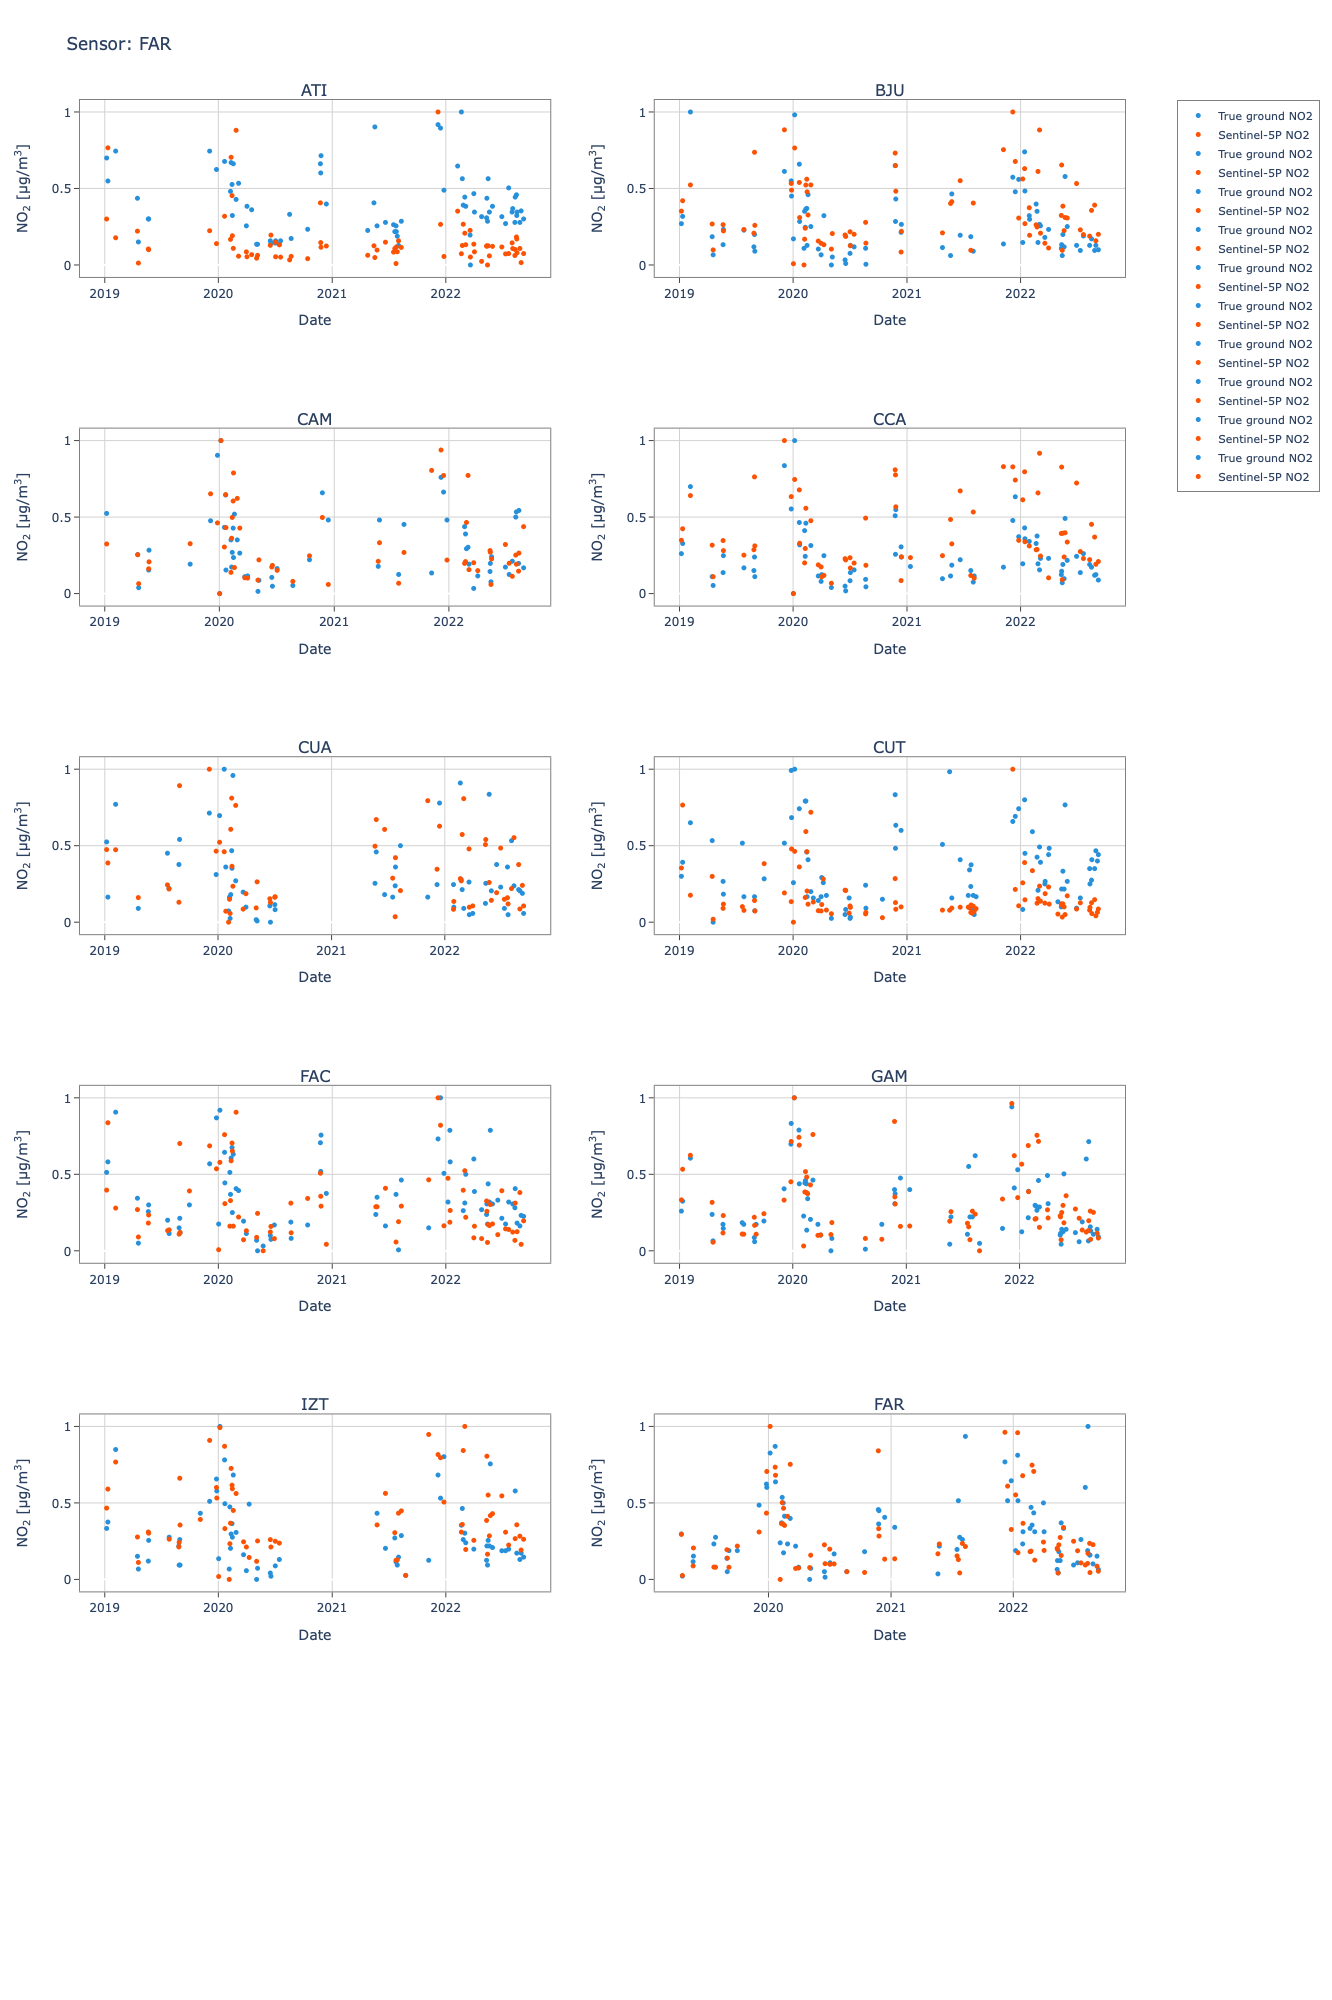

In [38]:
test_grd_vs_sat = test[["station", "ground_no2", "satellite_no2"]]
test_grd_vs_sat.reset_index(drop=False, inplace=True)
test_grd_vs_sat = test_grd_vs_sat.groupby(["date", "station"]).mean()
test_grd_vs_sat.reset_index(drop=False, inplace=True)

fig = go.Figure()
column = 1
row = 1
fig = make_subplots(
    cols=2, rows=int(len(sensors_list) / 2) + 1, subplot_titles=(sensors_list_str)
)


for sensor in sensors_list:
    test_grd_vs_sat_sensor = test_grd_vs_sat[test_grd_vs_sat["station"] == sensor]
    test_grd_vs_sat_sensor.drop(["station"], axis=1, inplace=True)
    test_grd_vs_sat_sensor.set_index("date", inplace=True, drop=True)
    test_grd_vs_sat_sensor.sort_index(inplace=True)
    test_grd_vs_sat_sensor = (test_grd_vs_sat_sensor - test_grd_vs_sat_sensor.min()) / (
        test_grd_vs_sat_sensor.max() - test_grd_vs_sat_sensor.min()
    )

    if column % 2 == 1:
        plot_grd_vs_sat(test_grd_vs_sat_sensor, row, column, sensor, True)
        column += 1
    else:
        plot_grd_vs_sat(test_grd_vs_sat_sensor, row, column, sensor, True)
        column -= 1
        row += 1

fig.update_layout(height=2000)
# Show the plot
fig.show()

In [53]:
np.corrcoef(pred_est["ground_no2"], pred_est["predicted"])

array([[1.        , 0.51251466],
       [0.51251466, 1.        ]])

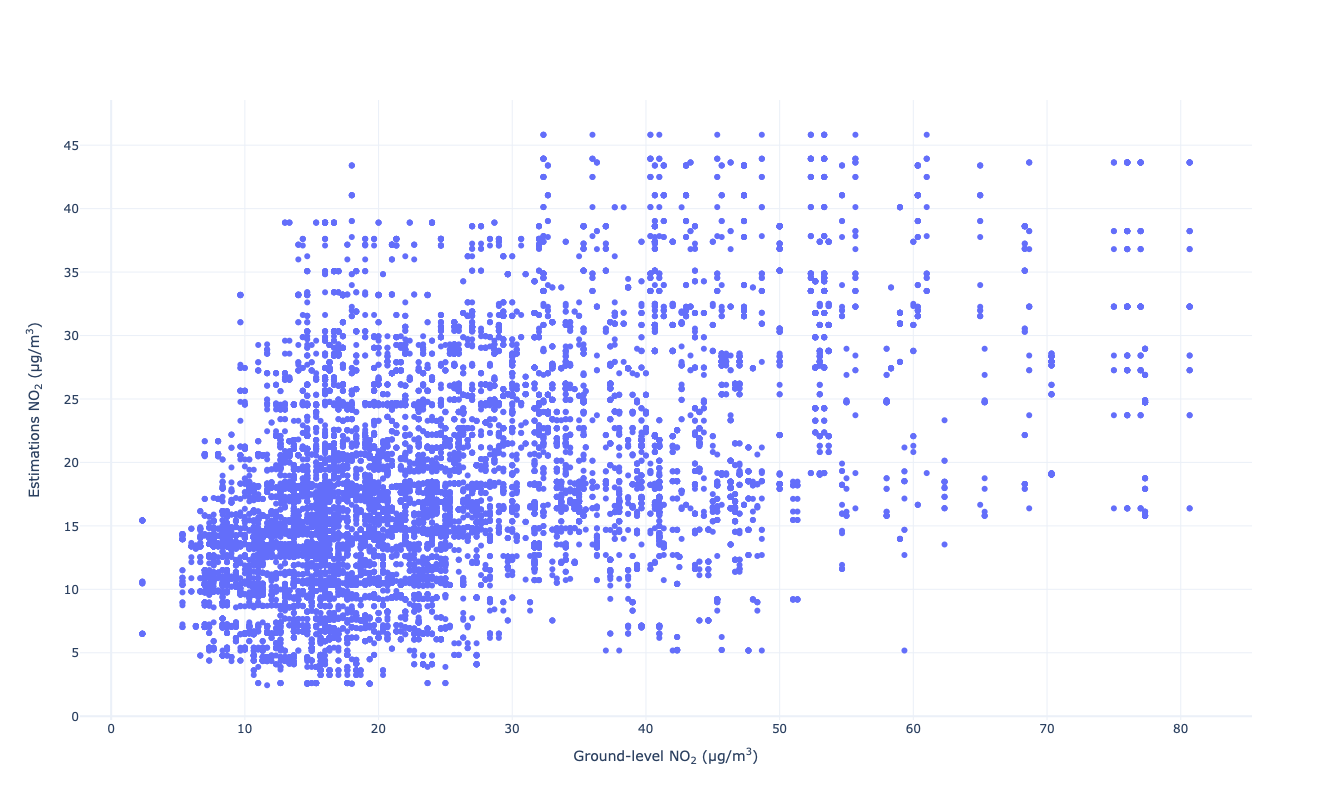

In [52]:
# Create the scatter plot
fig = go.Figure(
    data=go.Scatter(
        x=pred_est["ground_no2"],
        y=pred_est["predicted"],
        mode="markers",  # 'lines+markers' can be used if you want to connect the points
        # marker=dict(color="blue", size=10),  # Customize the markers (optional)
    )
)

# Customize layout
fig.update_layout(
    xaxis_title="Ground-level NO<sub>2</sub> (µg/m<sup>3</sup>)",
    yaxis_title="Estimations NO<sub>2</sub> (µg/m<sup>3</sup>)",
    template="plotly_white",  # Optional: set a template for the plot's appearance
    height=800,
    width=800,
)

# Show the plot
fig.show()

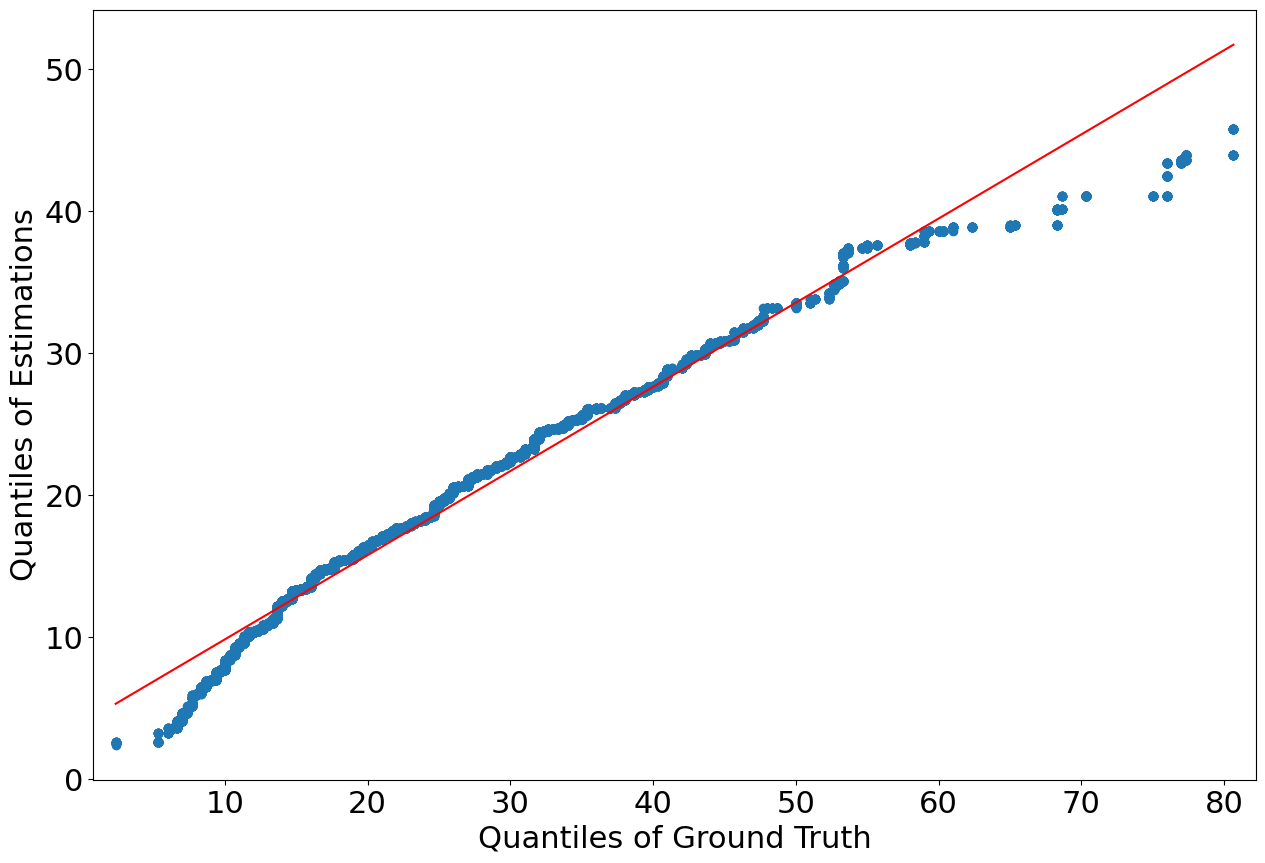

In [40]:
font = {"size": 22}

with mpl.rc_context():
    mpl.rc("figure", figsize=(15, 10))
    mpl.rc("font", **font)
    qqplot_2samples(
        pred_est["ground_no2"],
        pred_est["predicted"],
        xlabel="Quantiles of Ground Truth",
        ylabel="Quantiles of Estimations",
        line="r",
    )

# Save the plot
plt.savefig(
    "/Users/rodrigo/Documents/2_PoliMi/3_Research/Papers/MDPI_2024/images/qqplot_est_vs_truth.png",
    dpi=300,
    bbox_inches="tight",
)

plt.show()

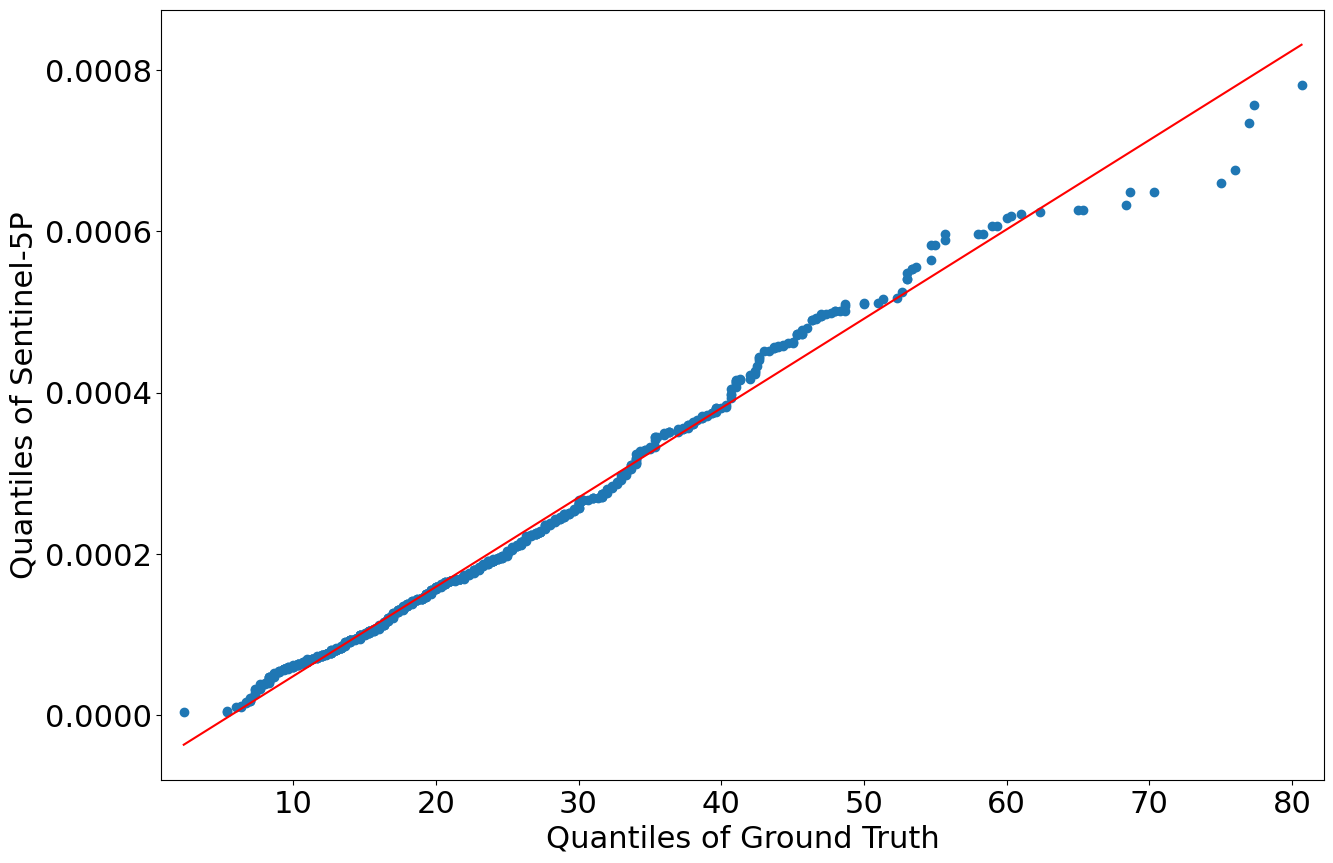

In [42]:
font = {"size": 22}

with mpl.rc_context():
    mpl.rc("figure", figsize=(15, 10))
    mpl.rc("font", **font)
    qqplot_2samples(
        test_grd_vs_sat["ground_no2"],
        test_grd_vs_sat["satellite_no2"],
        xlabel="Quantiles of Ground Truth",
        ylabel="Quantiles of Sentinel-5P",
        line="r",
    )
# Save the plot
plt.savefig(
    "/Users/rodrigo/Documents/2_PoliMi/3_Research/Papers/MDPI_2024/images/qqplot_sat_vs_truth.png",
    dpi=300,
    bbox_inches="tight",
)

plt.show()

In [ ]:
font = {"size": 22}

with mpl.rc_context():
    mpl.rc("figure", figsize=(15, 10))
    mpl.rc("font", **font)
    qqplot_2samples(
        pred_est["ground_no2"],
        pred_est["predicted"],
        xlabel="Quantiles of Ground Truth",
        ylabel="Quantiles of Estimations",
        line="r",
    )

# Save the plot
plt.savefig(
    "/Users/rodrigo/Documents/2_PoliMi/3_Research/Papers/MDPI_2024/images/qqplot_est_vs_truth.png",
    dpi=300,
    bbox_inches="tight",
)

plt.show()

<Figure size 1000x1000 with 0 Axes>

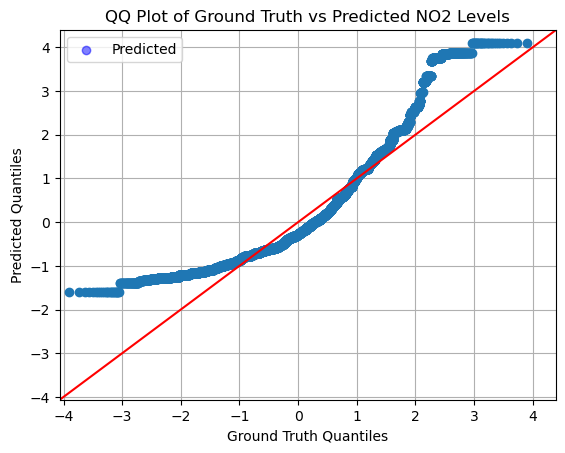

In [47]:
# Sort the values for QQ plot
pred_est = pred_est.sort_values(by="ground_no2")

# Create a QQ plot comparing Ground Truth vs Predicted
plt.figure(figsize=(10, 10))

# Plot the quantiles of the ground truth vs the predicted values
sm.qqplot(pred_est["ground_no2"], line="45", fit=True)
plt.scatter(
    pred_est["ground_no2"],
    pred_est["predicted"],
    color="blue",
    alpha=0.5,
    label="Predicted",
)

plt.title("QQ Plot of Ground Truth vs Predicted NO2 Levels")
plt.xlabel("Ground Truth Quantiles")
plt.ylabel("Predicted Quantiles")
plt.legend()
plt.grid()

# Show the plot
plt.show()

In [48]:
pred_est

ground_no2  predicted
date                             
2022-03-21    2.333333  10.469967
2022-03-21    2.333333  15.427772
2022-03-21    2.333333  15.427772
2022-03-21    2.333333  15.427772
2022-03-21    2.333333   6.496457
...                ...        ...
2020-01-06   80.666664  36.807952
2020-01-06   80.666664  38.227258
2020-01-06   80.666664  32.277520
2020-01-06   80.666664  32.277520
2020-01-06   80.666664  32.277520

[21417 rows x 2 columns]

In [49]:
sensors_df_rmse = sensors_df.sort_values(by="sensor")
print("Mean RMSE: " + str(sensors_df_rmse["NRMSE"].mean()))
print("Median RMSE: " + str(sensors_df_rmse["NRMSE"].median()))
print("Std RMSE: " + str(sensors_df_rmse["NRMSE"].std()))
print(
    "Number of stations with RMSE below 1: "
    + str(len(sensors_df_rmse[sensors_df_rmse["NRMSE"] < 1]))
    + "/"
    + str(len(sensors_df_rmse["NRMSE"]))
)

Mean RMSE: 1.0090498682946267
Median RMSE: 0.9766637879989626
Std RMSE: 0.14398997814419992
Number of stations with RMSE below 1: 5/10


In [50]:
sensors_df_rmse["NRMSE"] = sensors_df_rmse["NRMSE"] * 100
sensors_df_rmse.iloc[:, 0:3]

sensor       NRMSE       RMSE
0    ATI  124.143499  11.484363
1    BJU   90.259736  13.156405
2    CAM   94.622508  14.578054
3    CCA   87.823224  12.414521
4    CUA  103.935717  10.529195
5    CUT  123.183989  12.160811
6    FAC  110.532830  13.845629
9    FAR   84.414721   9.039379
7    GAM   89.423395  12.299460
8    IZT  100.710250  14.549875

In [55]:
sensors_df["Corr"].mean()

0.5329596915717625

In [51]:
sensors_df_rmse = sensors_df_rmse[sensors_df_rmse["sensor"] != "GAM"]

In [52]:
median_rmse = sensors_df_rmse["NRMSE"].median()

In [53]:
median_rmse

100.71024994019491

# Maps

In [54]:
df_complete_plot = pd.read_csv(
    "/Users/rodrigo/Documents/2_PoliMi/3_Research/Pollution/Prediction/Data/cdmx-df_complete-2024_06_18.csv",
    index_col=0,
)
df_complete_plot.set_index("date", inplace=True)
df_complete_plot.drop(columns=["id"], inplace=True)

gs = gpd.GeoSeries.from_wkt(df_complete_plot["geometry"])
df_complete_plot = gpd.GeoDataFrame(df_complete_plot, geometry=gs, crs="EPSG:3857")

In [55]:
# Define the mapping
mapping = {
    0: "open_space",
    1: "nonresidential",
    2: "atomistic",
    3: "informal_subdivision",
    4: "formal_subdivision",
    5: "housing_project",
    6: "road",
}

# Apply the mapping to the 'category' column
df_complete_plot["landUse"] = df_complete_plot["landUse"].map(mapping)

In [56]:
df_complete_plot = df_complete_plot[df_complete_plot["station"].isin(station_list)]
df_complete_plot = df_complete_plot[df_complete_plot["station"] != "ACO"]
df_complete_plot = df_complete_plot[df_complete_plot["station"] != "AJM"]
df_complete_plot = df_complete_plot[df_complete_plot["station"] != "CHO"]

In [57]:
sensors_df_rmse = sensors_df_rmse.merge(
    df_complete_plot, how="left", left_on="sensor", right_on="station"
)[
    [
        "sensor",
        "geometry",
        "NRMSE",
        "RMSE",
        "Corr",
        "St_Dev",
        "Data Size",
        "elevation",
        "landUse",
    ]
]

gs = sensors_df_rmse["geometry"]
sensors_df_rmse = gpd.GeoDataFrame(sensors_df_rmse, geometry=gs, crs="EPSG:3857")

sensors_df_rmse.drop_duplicates(subset="geometry", inplace=True)

In [58]:
sensors_df_rmse

sensor                           geometry       NRMSE       RMSE  \
0        ATI  POINT (-11048459.461 2224966.628)  124.143499  11.484363   
5283     BJU  POINT (-11041501.993 2199136.228)   90.259736  13.156405   
19508    CAM  POINT (-11041501.993 2212047.067)   94.622508  14.578054   
23909    CCA  POINT (-11041501.993 2193605.668)   87.823224  12.414521   
26141    CUA  POINT (-11055416.929 2199136.228)  103.935717  10.529195   
26607    CUT  POINT (-11041501.993 2228659.542)  123.183989  12.160811   
27235    FAC  POINT (-11048459.461 2212047.067)  110.532830  13.845629   
27810    FAR  POINT (-11027587.057 2212047.067)   84.414721   9.039379   
28402    IZT  POINT (-11034544.525 2199136.228)  100.710250  14.549875   

           Corr     St_Dev  Data Size  elevation             landUse  
0      0.579470   9.250877      240.0     2386.0  formal_subdivision  
5283   0.559484  14.576162      400.0     2473.0      nonresidential  
19508  0.586576  15.406539      177.0     2249.0  formal_subdivision  
23909  0.579848  14.135807      150.0     2288.0      nonresidential  
26141  0.354202  10.130488       63.0        NaN          open_space  
26607  0.481784   9.872071       88.0        NaN      nonresidential  
27235  0.458633  12.526259       79.0        NaN      nonresidential  
27810  0.550711  10.708297       80.0        NaN  formal_subdivision  
28402  0.603385  14.447264       70.0        NaN      nonresidential

In [59]:
sensors_df_rmse["NRMSE"].median()

100.71024994019491

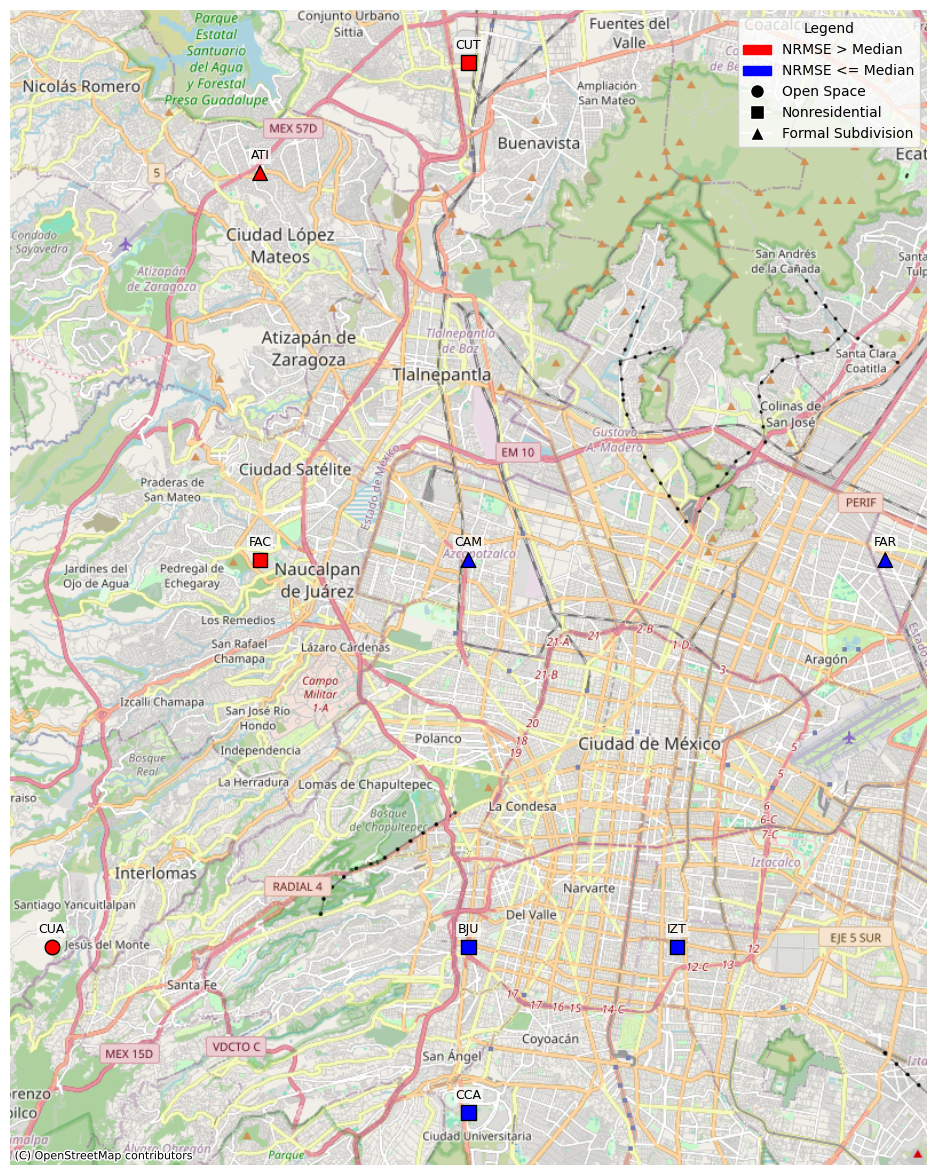

In [60]:
# Define different shapes for different land use categories
shapes = {
    "open_space": "o",  # circle
    "nonresidential": "s",  # square
    "formal_subdivision": "^",  # triangle
    "housing_project": "D",  # diamond
}

# Plotting
fig, ax = plt.subplots(figsize=(15, 15))

# Iterate over land use categories and plot each category with different shapes and color logic
for land_use, shape in shapes.items():
    subset = sensors_df_rmse[sensors_df_rmse["landUse"] == land_use]

    # Define the color based on the NRMSE value
    colors = ["red" if value > (median_rmse) else "blue" for value in subset["NRMSE"]]

    # Plot each subset with the corresponding shape and color
    subset.plot(
        ax=ax,
        marker=shape,
        label=f"Land Use {land_use}",
        markersize=110,
        color=colors,
        edgecolor="black",
    )

    # Add labels for each marker
    for idx, row in subset.iterrows():
        ax.annotate(
            row["sensor"],  # Adjust this to the column name that has station names
            (row.geometry.x, row.geometry.y),
            textcoords="offset points",
            xytext=(0, 10),
            ha="center",
            fontsize=9,
            bbox=dict(facecolor="white", alpha=0.7, edgecolor="none", pad=1),
        )

# Add the basemap
ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)

# Automatically adjust the plot extent to the bounding box of the geometries
xmin, ymin, xmax, ymax = sensors_df_rmse.total_bounds

# Calculate the range
x_range = xmax - xmin
y_range = ymax - ymin

# Extend the limits by 5%
xmin -= 0.05 * x_range
xmax += 0.05 * x_range
ymin -= 0.05 * y_range
ymax += 0.05 * y_range

# Set new limits
ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)

# Optionally, set axis off for a cleaner look
ax.set_axis_off()

# Define custom legend handles and labels
handles = [
    mpatches.Patch(color="red", label="NRMSE > Median"),
    mpatches.Patch(color="blue", label="NRMSE <= Median"),
    Line2D(
        [0],
        [0],
        marker="o",
        color="w",
        label="Open Space",
        markerfacecolor="black",
        markersize=10,
    ),  # Reduced markersize
    Line2D(
        [0],
        [0],
        marker="s",
        color="w",
        label="Nonresidential",
        markerfacecolor="black",
        markersize=10,
    ),  # Reduced markersize
    Line2D(
        [0],
        [0],
        marker="^",
        color="w",
        label="Formal Subdivision",
        markerfacecolor="black",
        markersize=10,
    ),  # Reduced markersize
]

# Add custom legend
ax.legend(handles=handles, title="Legend", loc="upper right")

# Save the plot
plt.savefig(
    "/Users/rodrigo/Documents/2_PoliMi/3_Research/Papers/MDPI_2024/images/map_landuse.png",
    dpi=300,
    bbox_inches="tight",
)

# Show the plot
plt.show()

KeyError: 'altitude'

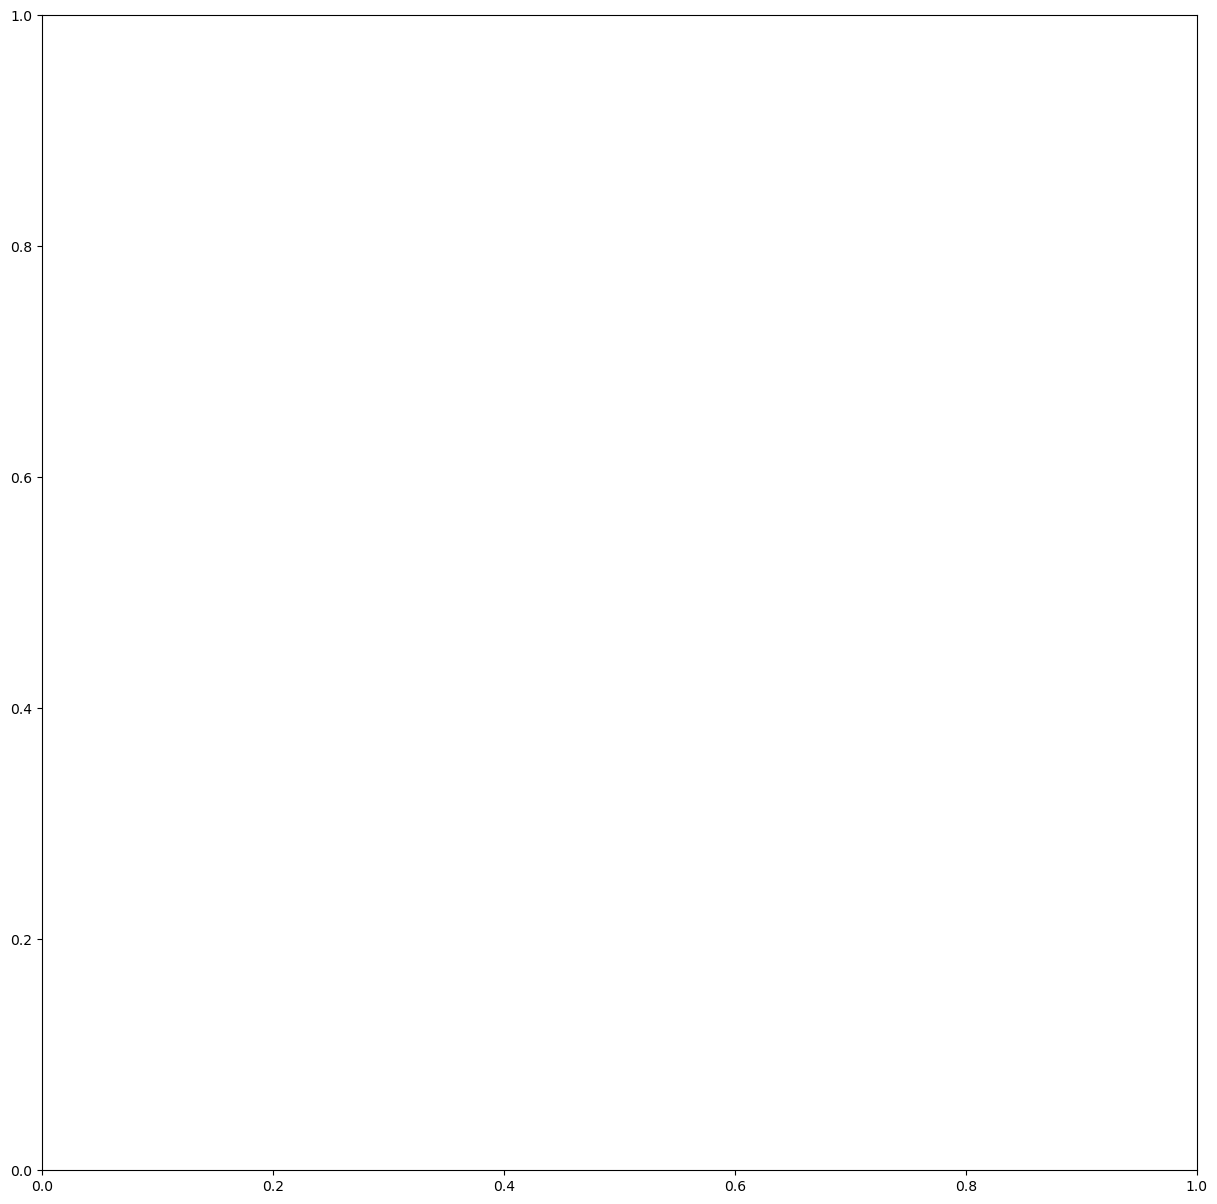

In [44]:
# Plotting
fig, ax = plt.subplots(figsize=(15, 15))

# Define the specific range for the color ramp
vmin = 0.9
vmax = 1

# Plot the GeoDataFrame
sensors_df_rmse.plot(
    column="altitude",
    ax=ax,
    legend=True,
    cmap="viridis",
    alpha=1,
    markersize=250,
    vmin=vmin,
    vmax=vmax,
)

# Add the basemap
ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)

# Automatically adjust the plot extent to the bounding box of the geometries
xmin, ymin, xmax, ymax = sensors_df_rmse.total_bounds
ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)

# Optionally, set axis off for a cleaner look
ax.set_axis_off()

# Show the plot
plt.show()

# General Statistics

In [ ]:
from scipy import stats

In [ ]:
pear_coef = np.corrcoef(test_y, inv_yhat_bst.reshape(len(inv_yhat_bst), ))[0]
spear_coef = stats.spearmanr(test_y, inv_yhat_bst.reshape(len(inv_yhat_bst), ))[0]
kendall_coef = stats.kendalltau(test_y, inv_yhat_bst.reshape(len(inv_yhat_bst), ))[0]
print('Pearson Corr between estimation and real data: %.2f' %pear_coef[1] + '\n' + 
      'Spearman Corr between estimation and real data: %.2f' %spear_coef + '\n' + 
      'Kendall Corr between estimation and real data: %.2f' %kendall_coef)

In [ ]:
len(test_y)

In [ ]:
print('Data mean: '+ str(df_complete['ground_no2'].mean()))
print('Data median: '+ str(df_complete['ground_no2'].median()))
print('Data min: '+ str(df_complete['ground_no2'].min()))
print('Data max: '+ str(df_complete['ground_no2'].max()))
print('Data std. dev.: '+ str(df_complete['ground_no2'].std()))

In [ ]:
print('Test Mean: %.3f' %test_y.mean() + '\n' + 
      'Test Max: %.3f' %test_y.max()+ '\n' + 
      'Test Min: %.3f' %test_y.min()+ '\n' + 
      'Test St.Dev.: %.3f' %test_y.std()+ '\n' + '\n'
      'Best model mean.: %.3f' %inv_yhat_bst.mean()+ '\n' + 
      'Best model St.Dev.: %.3f' %inv_yhat_bst.std()+ '\n'+
      'Best model min.: %.3f' %inv_yhat_bst.min()+ '\n'+  
      'Best model max.: %.3f' %inv_yhat_bst.max()+ '\n')

In [ ]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=test_y, y=train_y, mode="markers"))
#trace = go.Histogram(
 #   x=df_complete['ground_no2'][df_complete.index < '2022-03-07']
#)
fig.show()

## Peaks Analysis

In [ ]:
residuals = test_y-inv_yhat_bst.reshape(test_y.shape)
residuals_df = pd.DataFrame(residuals, columns=['residual'])
residuals_df.set_index(test_dates, inplace=True)
res_mean = residuals_df.mean().values[0]
res_std = residuals_df.std().values[0]
print('Residuals mean: '+str(res_mean))
print('Residuals std: '+str(res_std))

In [ ]:
sqm_3_df = residuals_df[residuals_df['residual']>3*res_std]

In [ ]:
sqm_3_df

In [ ]:
df_complete[df_complete.index == '2022-03-24']

In [ ]:
from plotly.subplots import make_subplots
# specify columns to plot
i = 1
j = 1
# plot each column
fig = make_subplots(rows=len(df_train_normalized.columns), cols=1)


for column in df_train_graph.columns:
  if column != 'index':
    fig.add_trace(
      go.Scatter(y=(df_complete[column][(df_complete.index >'2022-03-15')&(df_complete.index <'2022-04-10')]), x=(df_complete.index[(df_complete.index>'2022-03-15')&(df_complete.index <'2022-04-10')]), name = column),
      row=j, col=1
    )
    j += 1
fig.update_layout(height=1500, title_text="Normalized data vs. Original data")
fig.show()